In [1]:
import pandas as pd

pd.options.display.float_format = '{: .2f}'.format

charger_info = pd.read_csv('../data/station_info/한국전력공사_전기차충전소 용도 및 충전타입_20220718.csv', encoding='cp949')
station_coord =  pd.read_csv('../data/station_info/한국전력공사_전기차충전소위경도_20220718.csv')
station_loc = pd.read_excel('../data/station_info/한국전력공사_충전소의 위치 및 현황 정보_20220801.xlsx')

charge = pd.read_csv('../data/한국전력공사_전기차충전소충전량(202107_202112).csv', 
                 parse_dates=['충전종료일자', '충전시작시각', '충전종료시각'], 
                 encoding='cp949')

In [2]:
display(charger_info.head(3))
display(station_coord.head(3))
display(station_loc.head(3))

,본부,사업소,충전소명,충전기ID,충전기용량,충전기명,충전소구분,충전방식
0,강원,강릉,교동e-편한세상 아파트,3212,50.00,급속01,아파트용,DC차데모+DC콤보+AC3상(급속)
1,강원,강릉,교동e-편한세상 아파트,3213,7.00,완속01,아파트용,BC타입5핀(완속)
2,강원,강릉,교동e-편한세상 아파트,3214,7.00,완속02,아파트용,BC타입5핀(완속)


,시도,충전소명,경도,위도
0,강원도,강릉더샵 아파트,37.75,128.91
1,강원도,강릉특별지사,37.78,128.92
2,강원도,그린내하우스,37.76,128.92


,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,등록일자
0,2891,역삼래미안,서울특별시 강남구 역삼동 757,지하2층 107동 3-4라인,37.50,127.05,24시간,1899-2100,2017-12-26 17:53:33
1,2892,현대까르띠에710아파트,서울특별시 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,37.50,127.04,24시간,1899-2100,2017-12-26 17:53:34
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,36.38,127.32,24시간,1899-2100,2017-12-26 17:53:37


## 1. Table 생성 : STATION

In [3]:
station = charge[['본부', '사업소', '충전소명']].copy().drop_duplicates()
station['sid'] = station.본부.add('_').add(station.사업소).add('_').add(station.충전소명)
station = station.drop(columns=['본부', '사업소'])

In [4]:
station.head()

,충전소명,sid
0,강원직할,강원_강원직할_강원직할
1,남서울직할,남서울_남서울직할_남서울직할
5,여수청솔1차 아파트,광주전남_여수_여수청솔1차 아파트
9,고양지사,경기북부_고양_고양지사
10,양평지사,경기북부_양평_양평지사


In [5]:
charger_info['sid'] = charger_info.본부.add('_').add(charger_info.사업소).add('_').add(charger_info.충전소명)
charger_info = charger_info.drop(columns=['본부', '사업소', '충전소명']).drop_duplicates(['sid', '충전소구분'])

In [6]:
temp_cnt = charger_info.sid.value_counts()
charger_info[charger_info.sid.isin(temp_cnt[temp_cnt>1].index)]

,충전기ID,충전기용량,충전기명,충전소구분,충전방식,sid
2476,1395,7.00,완속03,업무용,BC타입5핀(완속),경기북부_파주_파주지사 신사옥
2483,9796,50.00,급속01,공용,DC콤보(급속),경기북부_파주_파주지사 신사옥
3489,1076,7.00,완속01,업무용,BC타입5핀(완속),경북_청송_청송지사
3491,8811,50.00,급속01,공용,DC차데모+DC콤보+AC3상(급속),경북_청송_청송지사


In [7]:
# 한 충전소에 용도가 두가지인 경우 제외 (선택 불가)
charger_info = charger_info.drop_duplicates(['sid'], keep=False)
charger_info.head(3)

,충전기ID,충전기용량,충전기명,충전소구분,충전방식,sid
0,3212,50.00,급속01,아파트용,DC차데모+DC콤보+AC3상(급속),강원_강릉_교동e-편한세상 아파트
3,4324,50.00,급속01,아파트용,DC차데모+DC콤보+AC3상(급속),강원_강릉_강릉더샵 아파트
5,4329,50.00,급속01,아파트용,DC차데모+DC콤보+AC3상(급속),강원_강릉_청송 아파트


In [8]:
station = station.merge(charger_info[['sid', '충전소구분']], how='left', on='sid')

In [9]:
station.head()

,충전소명,sid,충전소구분
0,강원직할,강원_강원직할_강원직할,업무용
1,남서울직할,남서울_남서울직할_남서울직할,업무용
2,여수청솔1차 아파트,광주전남_여수_여수청솔1차 아파트,아파트용
3,고양지사,경기북부_고양_고양지사,업무용
4,양평지사,경기북부_양평_양평지사,업무용


In [10]:
station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   충전소명    6701 non-null   object
 1   sid     6701 non-null   object
 2   충전소구분   3987 non-null   object
dtypes: object(3)
memory usage: 209.4+ KB


### 1) 공용 충전소만 선택 (PUB_STATION)

In [11]:
pub_station = station[station.충전소구분 == '공용'].copy().drop(columns=['충전소구분'])

In [12]:
pub_station.head()

,충전소명,sid
22,화양강휴게소,강원_홍천_화양강휴게소
24,상암월드컵경기장,서울_마포용산_상암월드컵경기장
30,대정읍사무소,제주_서귀포_대정읍사무소
32,애월119센터,제주_제주직할_애월119센터
37,수성구민운동장,대구_동대구_수성구민운동장


### 2)  spatial key 추가
- 주소
- 좌표

In [13]:
# station_loc에 존재하는 충전소ID가 pub_station에 없기 때문에, 충전소명을 키로 활용할 수 밖에 없음
# pub_station의 본부사업소에서 알수있는 지역과 station_loc의 주소를 활용하여 중복충전소명을 처리할 수 있지만
# 수동 작업에 시간 소요가 크므로, 일단 중복 충전소명을 제거.
station_loc = station_loc[['충전소명', '충전소주소', '위도', '경도']].drop_duplicates(['충전소명'], keep=False)

In [14]:
station_loc

,충전소명,충전소주소,위도,경도
0,역삼래미안,서울특별시 강남구 역삼동 757,37.50,127.05
1,현대까르띠에710아파트,서울특별시 강남구 역삼동 710,37.50,127.04
2,열매마을5단지,대전광역시 유성구 지족동 877,36.38,127.32
3,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,35.24,128.50
4,팜스프링아파트,경기도 파주시 금촌동 7,37.77,126.78
...,...,...,...,...
4767,백운면 행정복지센터,충청북도 제천시 백운면 평동리 209-2,37.14,128.03
4768,스퀘어원,인천광역시 연수구 동춘동 926,37.41,126.68
4770,산청읍사무소,경상남도 산청군 산청읍 지리 321-6,35.41,127.88
4771,화도면사무소,인천광역시 강화군 화도면 상방리 839-1,37.63,126.42


In [15]:
pub_station = pub_station.merge(station_loc[['충전소명', '충전소주소', '위도', '경도']], how='left', on='충전소명')

In [16]:
pub_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1339 entries, 0 to 1338
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   충전소명    1339 non-null   object 
 1   sid     1339 non-null   object 
 2   충전소주소   1310 non-null   object 
 3   위도      1320 non-null   float64
 4   경도      1320 non-null   float64
dtypes: float64(2), object(3)
memory usage: 62.8+ KB


In [17]:
# 충전소 구분, 주소, 위경도 정보 모두 필요하므로, null 행 제거
pub_station = pub_station.dropna()

In [18]:
pub_station.head()

,충전소명,sid,충전소주소,위도,경도
0,화양강휴게소,강원_홍천_화양강휴게소,강원도 홍천군 두촌면 철정리 978-6,37.80,127.99
1,상암월드컵경기장,서울_마포용산_상암월드컵경기장,서울특별시 마포구 성산동 531,37.57,126.89
2,대정읍사무소,제주_서귀포_대정읍사무소,제주특별자치도 서귀포시 대정읍 하모리 1413,33.23,126.25
3,애월119센터,제주_제주직할_애월119센터,제주특별자치도 제주시 애월읍 일주서로 6513,33.47,126.35
4,수성구민운동장,대구_동대구_수성구민운동장,대구광역시 수성구 범어동 630-1,35.85,128.63


In [19]:
# 컬럼명 영문으로 통일
colname_encoder = dict(충전소명='station_name', 충전소주소='address', 위도='lat', 경도='long')
pub_station = pub_station.rename(columns=colname_encoder)

In [20]:
# 시군구(district_lv2), 읍면동(district_lv3) 컬럼 생성
address_array = pub_station.address.map(lambda x: x.split())
pub_station['district_lv2'] = address_array.map(lambda x: x[0] + '_' + x[1])
pub_station['district_lv3'] = address_array.map(lambda x: x[0] + '_' + x[1] + '_' + x[2])

In [21]:
pub_station.head()

,station_name,sid,address,lat,long,district_lv2,district_lv3
0,화양강휴게소,강원_홍천_화양강휴게소,강원도 홍천군 두촌면 철정리 978-6,37.80,127.99,강원도_홍천군,강원도_홍천군_두촌면
1,상암월드컵경기장,서울_마포용산_상암월드컵경기장,서울특별시 마포구 성산동 531,37.57,126.89,서울특별시_마포구,서울특별시_마포구_성산동
2,대정읍사무소,제주_서귀포_대정읍사무소,제주특별자치도 서귀포시 대정읍 하모리 1413,33.23,126.25,제주특별자치도_서귀포시,제주특별자치도_서귀포시_대정읍
3,애월119센터,제주_제주직할_애월119센터,제주특별자치도 제주시 애월읍 일주서로 6513,33.47,126.35,제주특별자치도_제주시,제주특별자치도_제주시_애월읍
4,수성구민운동장,대구_동대구_수성구민운동장,대구광역시 수성구 범어동 630-1,35.85,128.63,대구광역시_수성구,대구광역시_수성구_범어동


In [22]:
# 총 1_310 행
pub_station.shape

(1310, 7)

## 2. Table 생성 :  CHARGER

In [23]:
charge.head()

,본부,사업소,충전소명,충전기,충전기ID,주소,충전기구분,충전용량,충전량,충전시간,충전분,충전종료일자,충전시작시각,충전종료시각
0,강원,강원직할,강원직할,완속05,1296,강원도 춘천시 수풍골길 7,완속,7.00,13.17,2,39,2021-07-01,2021-07-01 19:35:55,2021-07-01 22:15:42
1,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,15.84,0,24,2021-07-01,2021-07-01 14:30:46,2021-07-01 14:54:51
2,남서울,남서울직할,남서울직할,급속01,8858,서울특별시 영등포구 여의도동 21,급속,50.00,11.70,0,43,2021-07-01,2021-07-01 16:52:38,2021-07-01 17:36:36
3,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.40,1,23,2021-07-01,2021-07-01 10:58:58,2021-07-01 12:22:29
4,강원,강원직할,강원직할,완속02,1293,강원도 춘천시 수풍골길 7,완속,7.00,5.53,2,11,2021-07-01,2021-07-01 16:46:25,2021-07-01 18:58:12


In [24]:
charger = charge[['본부', '사업소', '충전소명', '충전기', '충전기ID', '충전기구분', '충전용량']].drop_duplicates()
charger['sid'] = charger.본부.add('_').add(charger.사업소).add('_').add(charger.충전소명)
charger = charger.drop(columns=['본부', '사업소', '충전소명'])

In [25]:
display(charger.head(3))
charger.info()

,충전기,충전기ID,충전기구분,충전용량,sid
0,완속05,1296,완속,7.00,강원_강원직할_강원직할
1,급속01,8858,급속,50.00,남서울_남서울직할_남서울직할
3,완속02,1293,완속,7.00,강원_강원직할_강원직할


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13771 entries, 0 to 1048388
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   충전기     13771 non-null  object 
 1   충전기ID   13771 non-null  int64  
 2   충전기구분   13771 non-null  object 
 3   충전용량    9557 non-null   float64
 4   sid     13771 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 645.5+ KB


In [26]:
# 충전용량이 없는 충전기 및 해당 충전기를 포함한 충전소를 데이터에서 제거
null_stations = charger[charger.충전용량.isna()].sid.unique()
# 6개 존재
pub_station.sid.isin(null_stations).sum()

6

In [27]:
pub_station = pub_station[~pub_station.sid.isin(null_stations)]
charger = charger[charger.sid.isin(pub_station.sid)]

In [28]:
charger

,충전기,충전기ID,충전기구분,충전용량,sid
32,급속01,8676,급속,50.00,강원_홍천_화양강휴게소
35,급속05,609,급속,50.00,서울_마포용산_상암월드컵경기장
41,급속04,9787,급속,50.00,제주_서귀포_대정읍사무소
43,급속02,1449,급속,50.00,제주_제주직할_애월119센터
48,급속01,681,급속,50.00,대구_동대구_수성구민운동장
...,...,...,...,...,...
956401,급속02,6784,급속,50.00,대전세종충남_세종_2생활권 환승주차장2(B)
957263,급속01,804,급속,50.00,인천_강화_강화지사
969413,급속01,10691,급속,50.00,경남_창녕_대합일반산업단지 전기차 충전소
978671,급속01,10764,급속,50.00,대전세종충남_공주_중동공영주차타워


In [29]:
# 컬럼명 영문으로 통일
colname_encoder = dict(충전기='charger_name', 충전기ID='cid', 충전기구분='charger_type', 충전용량='speed')
charger = charger.rename(columns=colname_encoder)

In [30]:
charger

,charger_name,cid,charger_type,speed,sid
32,급속01,8676,급속,50.00,강원_홍천_화양강휴게소
35,급속05,609,급속,50.00,서울_마포용산_상암월드컵경기장
41,급속04,9787,급속,50.00,제주_서귀포_대정읍사무소
43,급속02,1449,급속,50.00,제주_제주직할_애월119센터
48,급속01,681,급속,50.00,대구_동대구_수성구민운동장
...,...,...,...,...,...
956401,급속02,6784,급속,50.00,대전세종충남_세종_2생활권 환승주차장2(B)
957263,급속01,804,급속,50.00,인천_강화_강화지사
969413,급속01,10691,급속,50.00,경남_창녕_대합일반산업단지 전기차 충전소
978671,급속01,10764,급속,50.00,대전세종충남_공주_중동공영주차타워


### 충전구 개수 정보 PUB_STATION에 추가

In [31]:
charger_cnt = charger.groupby(['sid', 'charger_type']).cid.count().unstack().fillna(0).astype(int).rename(columns={'급속':'fast_cnt', '완속':'slow_cnt'})
charger_cnt.head(3)

charger_type,fast_cnt,slow_cnt
sid,,
강원_강릉_HAPPY700 평창시네마,1,0
강원_강릉_감자연구소,1,0
강원_강릉_강남동주민센터,1,0


In [32]:
pub_station = pub_station.merge(charger_cnt, how='left', on='sid')
pub_station.head(3)

,station_name,sid,address,lat,long,district_lv2,district_lv3,fast_cnt,slow_cnt
0,화양강휴게소,강원_홍천_화양강휴게소,강원도 홍천군 두촌면 철정리 978-6,37.80,127.99,강원도_홍천군,강원도_홍천군_두촌면,1,0
1,상암월드컵경기장,서울_마포용산_상암월드컵경기장,서울특별시 마포구 성산동 531,37.57,126.89,서울특별시_마포구,서울특별시_마포구_성산동,7,3
2,대정읍사무소,제주_서귀포_대정읍사무소,제주특별자치도 서귀포시 대정읍 하모리 1413,33.23,126.25,제주특별자치도_서귀포시,제주특별자치도_서귀포시_대정읍,4,0


### 충전용량 정보 PUB_STATION에 추가

In [33]:
# sid 별 평균 충전용량
mean_speed = charger[charger.charger_type == '급속'].groupby('sid').speed.mean()
mean_speed.head()

sid
강원_강릉_HAPPY700 평창시네마    50.00
강원_강릉_감자연구소             50.00
강원_강릉_강남동주민센터           50.00
강원_강릉_강릉농협 하나로마트        50.00
강원_강릉_강릉축협 하나로마트        50.00
Name: speed, dtype: float64

In [34]:
pub_station = pub_station.merge(mean_speed, how='left', on='sid').rename(columns={'speed':'mean_speed'})

In [35]:
pub_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1303
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  1304 non-null   object 
 1   sid           1304 non-null   object 
 2   address       1304 non-null   object 
 3   lat           1304 non-null   float64
 4   long          1304 non-null   float64
 5   district_lv2  1304 non-null   object 
 6   district_lv3  1304 non-null   object 
 7   fast_cnt      1304 non-null   int64  
 8   slow_cnt      1304 non-null   int64  
 9   mean_speed    1293 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 112.1+ KB


In [36]:
pub_station = pub_station.dropna()

In [37]:
pub_station.head(3)

,station_name,sid,address,lat,long,district_lv2,district_lv3,fast_cnt,slow_cnt,mean_speed
0,화양강휴게소,강원_홍천_화양강휴게소,강원도 홍천군 두촌면 철정리 978-6,37.80,127.99,강원도_홍천군,강원도_홍천군_두촌면,1,0,50.00
1,상암월드컵경기장,서울_마포용산_상암월드컵경기장,서울특별시 마포구 성산동 531,37.57,126.89,서울특별시_마포구,서울특별시_마포구_성산동,7,3,50.00
2,대정읍사무소,제주_서귀포_대정읍사무소,제주특별자치도 서귀포시 대정읍 하모리 1413,33.23,126.25,제주특별자치도_서귀포시,제주특별자치도_서귀포시_대정읍,4,0,50.00


## 3. CHARGE SEESION selection

In [38]:
charge['sid'] = charge.본부.add('_').add(charge.사업소).add('_').add(charge.충전소명)
charge.columns

Index(['본부', '사업소', '충전소명', '충전기', '충전기ID', '주소', '충전기구분', '충전용량', '충전량',
       '충전시간', '충전분', '충전종료일자', '충전시작시각', '충전종료시각', 'sid'],
      dtype='object')

In [39]:
charge = charge[['sid', '충전기ID', '충전량', '충전시간', '충전분', '충전종료일자', '충전시작시각', '충전종료시각']]
colname_encoder = dict(충전기ID='cid', 충전량='amount', 충전시간='hour', 충전분='minute', 충전종료일자='finish_date', 충전시작시각='start_time', 충전종료시각='finish_time')
charge = charge.rename(columns=colname_encoder)
charge.head(3)

,sid,cid,amount,hour,minute,finish_date,start_time,finish_time
0,강원_강원직할_강원직할,1296,13.17,2,39,2021-07-01,2021-07-01 19:35:55,2021-07-01 22:15:42
1,남서울_남서울직할_남서울직할,8858,15.84,0,24,2021-07-01,2021-07-01 14:30:46,2021-07-01 14:54:51
2,남서울_남서울직할_남서울직할,8858,11.70,0,43,2021-07-01,2021-07-01 16:52:38,2021-07-01 17:36:36


In [40]:
print(charge.shape)  # 전체 로그
charge = charge[charge.cid.isin(charger.cid)]
print(charge.shape)  # 분석대상 로그 (선택한 공용충전소)

(1048575, 8)
(342158, 8)


In [41]:
charge['duration'] = 60*charge.hour + charge.minute
charge.drop(columns=['hour', 'minute'], inplace=True)

In [42]:
# 7~12월 간의 데이터이지만 실질적으로 10월 17일까지의 로그만 존재함
charge.describe(datetime_is_numeric=True)

,cid,amount,finish_date,start_time,finish_time,duration
count,342158.00,342158.00,342158,342158,342158,342158.00
mean,5956.51,25.24,2021-08-24 01:51:11.191671296,2021-08-24 15:36:40.643395840,2021-08-24 16:34:46.405865216,57.60
min,7.00,0.00,2021-07-01 00:00:00,2018-05-21 11:56:10,2021-07-01 00:02:52,-120016.00
25%,1451.00,11.79,2021-07-28 00:00:00,2021-07-28 06:34:17.249999872,2021-07-28 07:26:19.249999872,24.00
50%,6681.00,21.29,2021-08-24 00:00:00,2021-08-24 14:45:56,2021-08-24 15:29:11.500000,42.00
75%,8756.00,34.17,2021-09-20 00:00:00,2021-09-20 18:39:01,2021-09-20 19:34:11.500000,66.00
max,11071.00,222153.35,2021-10-17 00:00:00,2022-01-01 01:51:38,2021-10-17 23:59:39,1780167.00
std,3532.44,438.16,NaN,NaN,NaN,3057.12


In [43]:
# 7~9의 3개월 데이터만 분리
charge = charge[charge.start_time.between('2021-07-01', '2021-10-01')]
charge.sid.nunique()

1299

In [44]:
# 실질적으로 활발히 운영되는 충전기로 한정하기 위하여, 분석기간(3개월) 내 첫주와 마지막주에 모두 충전시작이 있는 충전소로 제한

first_charge = charge.groupby('sid')['start_time'].min()
valid_id_first = first_charge[first_charge < '2021-07-07'].index

last_charge = charge.groupby('sid')['start_time'].max()
valid_id_last = last_charge[last_charge > '2021-09-23'].index

In [45]:
# 총 1051개의 충전소
valid_sid = set(valid_id_first).intersection(valid_id_last)
len(valid_sid)

1051

In [46]:
# 총 충전의 90% 이상이며 3개월간 276,114건
charge.sid.isin(valid_sid).mean(), charge.sid.isin(valid_sid).sum()

(0.9640784631392239, 276114)

In [47]:
charge = charge[charge.sid.isin(valid_sid)].copy()
charger = charger[charger.sid.isin(valid_sid)].copy()
pub_station = pub_station[pub_station.sid.isin(valid_sid)].copy()

In [48]:
charge.head()

,sid,cid,amount,finish_date,start_time,finish_time,duration
32,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59
35,서울_마포용산_상암월드컵경기장,609,31.63,2021-07-01,2021-07-01 20:55:34,2021-07-01 21:52:17,56
41,제주_서귀포_대정읍사무소,9787,20.19,2021-07-01,2021-07-01 21:24:08,2021-07-01 21:55:04,30
43,제주_제주직할_애월119센터,1449,39.12,2021-07-01,2021-07-01 22:05:25,2021-07-01 23:43:20,97
48,대구_동대구_수성구민운동장,681,38.96,2021-07-01,2021-07-01 20:30:54,2021-07-01 21:49:41,78


In [49]:
charge.describe(datetime_is_numeric=True)

,cid,amount,finish_date,start_time,finish_time,duration
count,276114.00,276114.00,276114,276114,276114,276114.00
mean,5842.61,24.32,2021-08-15 06:16:24.897542144,2021-08-15 20:06:53.422731264,2021-08-15 21:00:41.692634368,53.31
min,7.00,0.00,2021-07-01 00:00:00,2021-07-01 00:01:40,2021-07-01 00:15:27,0.00
25%,1435.00,11.80,2021-07-23 00:00:00,2021-07-23 17:16:22.500000,2021-07-23 18:04:55.249999872,24.00
50%,6178.00,21.23,2021-08-15 00:00:00,2021-08-15 08:08:34.500000,2021-08-15 09:09:56,42.00
75%,8728.00,34.16,2021-09-08 00:00:00,2021-09-08 05:55:58.750000128,2021-09-08 06:56:01.249999872,66.00
max,11065.00,48134.36,2021-10-05 00:00:00,2021-09-30 23:59:25,2021-10-05 09:12:42,9839.00
std,3505.69,130.35,NaN,NaN,NaN,78.37


In [50]:
charge = charge.merge(charger[['cid', 'charger_type']], how='left', on='cid')

In [51]:
charge.head()

,sid,cid,amount,finish_date,start_time,finish_time,duration,charger_type
0,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59,급속
1,서울_마포용산_상암월드컵경기장,609,31.63,2021-07-01,2021-07-01 20:55:34,2021-07-01 21:52:17,56,급속
2,제주_서귀포_대정읍사무소,9787,20.19,2021-07-01,2021-07-01 21:24:08,2021-07-01 21:55:04,30,급속
3,제주_제주직할_애월119센터,1449,39.12,2021-07-01,2021-07-01 22:05:25,2021-07-01 23:43:20,97,급속
4,대구_동대구_수성구민운동장,681,38.96,2021-07-01,2021-07-01 20:30:54,2021-07-01 21:49:41,78,급속


### 급속 선택

In [52]:
fast_charge = charge[charge.charger_type == '급속'].copy().drop(columns=['charger_type'])
fast_charge.head(3)

,sid,cid,amount,finish_date,start_time,finish_time,duration
0,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59
1,서울_마포용산_상암월드컵경기장,609,31.63,2021-07-01,2021-07-01 20:55:34,2021-07-01 21:52:17,56
2,제주_서귀포_대정읍사무소,9787,20.19,2021-07-01,2021-07-01 21:24:08,2021-07-01 21:55:04,30


In [53]:
fast_charge.describe(datetime_is_numeric=True)

,cid,amount,finish_date,start_time,finish_time,duration
count,264994.00,264994.00,264994,264994,264994,264994.00
mean,6015.40,24.69,2021-08-15 05:50:37.083104,2021-08-15 19:48:18.518423296,2021-08-15 20:36:02.857321728,47.25
min,7.00,0.00,2021-07-01 00:00:00,2021-07-01 00:01:40,2021-07-01 00:15:27,0.00
25%,1484.00,12.36,2021-07-23 00:00:00,2021-07-23 17:15:23.500000,2021-07-23 18:00:11.500000,24.00
50%,6689.00,21.68,2021-08-15 00:00:00,2021-08-15 07:05:36,2021-08-15 07:58:55,41.00
75%,8748.00,34.38,2021-09-08 00:00:00,2021-09-08 04:50:01.249999872,2021-09-08 05:47:18.500000,63.00
max,11065.00,48134.36,2021-10-05 00:00:00,2021-09-30 23:58:27,2021-10-05 09:12:42,9839.00
std,3440.00,133.01,NaN,NaN,NaN,55.24


### duration 이상치 필터링

In [54]:
fast_charge.duration.describe()

count    264994.00
mean         47.25
std          55.24
min           0.00
25%          24.00
50%          41.00
75%          63.00
max        9839.00
Name: duration, dtype: float64

In [55]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(fast_charge.duration)

(-124.71310057311325, 206.71310057311325)

In [56]:
# 206분 초과하는 경우 882건으로 전체 중 0.3% 가량
fast_charge.duration.gt(outlier_bound(fast_charge.duration)[1]).sum(), fast_charge.duration.gt(outlier_bound(fast_charge.duration)[1]).mean()

(882, 0.003328377246277274)

In [57]:
outlier_sid = fast_charge[fast_charge.duration.gt(outlier_bound(fast_charge.duration)[1])].sid.unique()

In [58]:
fast_charge = fast_charge[~fast_charge.sid.isin(outlier_sid)]

### 최종 선정 로그

In [59]:
fast_charge.head()

,sid,cid,amount,finish_date,start_time,finish_time,duration
0,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59
1,서울_마포용산_상암월드컵경기장,609,31.63,2021-07-01,2021-07-01 20:55:34,2021-07-01 21:52:17,56
4,대구_동대구_수성구민운동장,681,38.96,2021-07-01,2021-07-01 20:30:54,2021-07-01 21:49:41,78
6,제주_제주직할_제주 삼양 유적지,708,55.42,2021-07-01,2021-07-01 06:44:03,2021-07-01 08:17:31,93
7,남서울_구로금천_고척스카이돔,8035,43.88,2021-07-01,2021-07-01 20:33:32,2021-07-01 21:59:19,85


In [60]:
# 828개 충전소, 1,145개 충전기
fast_charge.sid.nunique(), fast_charge.cid.nunique()

(828, 1145)

count    1145.00
mean        1.82
std         1.56
min         0.01
25%         0.62
50%         1.37
75%         2.61
max         9.04
Name: sid, dtype: float64

<AxesSubplot: ylabel='Frequency'>

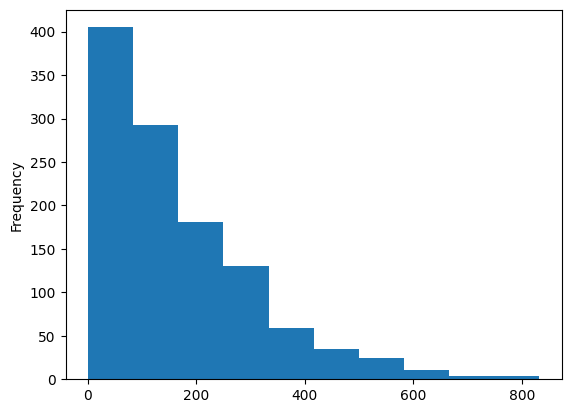

In [61]:
# 충전기당-일당 충전횟수는 최대 9.04회 최소 0.01회
display(fast_charge.groupby('cid')['sid'].count().divide(92).describe())

fast_charge.groupby('cid')['sid'].count().plot(kind='hist')

In [62]:
fast_charge.merge(charger[['cid', 'speed']], how='left', on='cid').groupby('speed').duration.mean()

speed
50.00     45.67
100.00    36.05
Name: duration, dtype: float64

# Target Feature Generation

### 1) point classification

In [63]:
def extract_occupancy_cls(cid_df, start_date, end_date, interval_min):
    """transform charge log table to occupancy-by-window table for each charging station id

    Args:
        cid_df (pd.DataFrame): charging station log table of one charging stationID
        start_date (str): YYYY-MM-DD
        end_date (str): YYYY-MM-DD
        interval_min (int): window size (minute)

    Returns:
        pd.Series: Returns occupancy at each point in time index
    """
    n_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    time_idx = pd.date_range(start=start_date,
                             freq=f'{interval_min}min',
                             periods=n_days*24*60//interval_min)

    result = np.full(time_idx.shape[0], False)
    for start_time, finish_time in zip(cid_df.start_time, cid_df.finish_time):
        occupied = (time_idx >= start_time) & (time_idx <= finish_time)
        result = result | occupied
    return pd.Series(data=result, index=time_idx, dtype='Int32')

#### 적용예시

In [65]:
cid_sample = fast_charge.query("cid == 8676")

In [70]:
extract_occupancy_cls(cid_df=cid_sample, start_date='2021-07-01', end_date='2021-09-30', interval_min=10)

2021-07-01 00:00:00    0
2021-07-01 00:10:00    0
2021-07-01 00:20:00    0
2021-07-01 00:30:00    0
2021-07-01 00:40:00    0
                      ..
2021-09-30 23:10:00    0
2021-09-30 23:20:00    0
2021-09-30 23:30:00    0
2021-09-30 23:40:00    0
2021-09-30 23:50:00    0
Freq: 10T, Length: 13248, dtype: Int32

In [73]:
from tqdm import tqdm
tqdm.pandas()

occupancy_cls = fast_charge.groupby('cid')[['start_time', 'finish_time']] \
                      .progress_apply(lambda df: extract_occupancy_cls(df, '2021-07-01', '2021-09-30', 10))

100%|██████████| 1145/1145 [00:38<00:00, 29.44it/s]


In [86]:
# 점유중->True
history_by_st = occupancy_cls.reset_index() \
                    .merge(fast_charge[['cid', 'sid']].drop_duplicates(), how='left', on='cid') \
                    .drop(columns=['cid']) \
                    .groupby('sid').all().astype(int)

In [118]:
history_by_st.mask(lambda x: x==1, 2).mask(lambda x: x==0, 1).mask(lambda x: x==2, 0) \
    .T.reset_index().rename(columns={'index':'time'}) \
    .to_csv('../data/input_table/fast_history_by_station_pub_cls.csv', index=False)

### 2)  period rate

In [63]:
def extract_occupancy_reg(cid_df, start_date, end_date, interval_min):
    """transform charge log table to occupancy-by-window table for each charging station id

    Args:
        cid_df (pd.DataFrame): charging station log table of one charging stationID
        start_date (str): YYYY-MM-DD
        end_date (str): YYYY-MM-DD
        interval_min (int): window size (minute)

    Returns:
        pd.Series: Returns the occupancy rate for each period
    """
    n_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    time_idx = pd.date_range(start=start_date, freq='10s', periods=n_days*24*60*6)
    
    start = pd.Series(index=cid_df.start_time, data=1, name='start').resample('10s').sum()
    assert start.le(1).all()
    finish = pd.Series(index=cid_df.finish_time, data=1, name='finish').resample('10s').sum()
    
    occupancy = pd.Series(index=time_idx, name='occupied', data=0).to_frame() \
        .join(start, how='left').join(finish, how='left')
    occupancy.start = occupancy.start.replace({1.:2.}).fillna(0)
    occupancy.finish = occupancy.finish.fillna(0)
    occupancy.occupied = occupancy.start.add(occupancy.finish).replace({0.:np.nan}).ffill().sub(1).fillna(0).astype('Int32')
    occupancy[occupancy.occupied.gt(1)] = 1
    
    return occupancy.resample(f'{interval_min}min').occupied.sum().divide(interval_min*6)


#### 적용 예시

In [64]:
cid_sample = charge.query("cid == 8676")

In [65]:
cid_sample

,sid,cid,amount,finish_date,start_time,finish_time,duration,charger_type
0,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59,급속
563,강원_홍천_화양강휴게소,8676,26.30,2021-07-01,2021-07-01 11:58:13,2021-07-01 12:45:53,47,급속
2055,강원_홍천_화양강휴게소,8676,2.17,2021-07-01,2021-07-01 11:18:03,2021-07-01 11:37:24,19,급속
2594,강원_홍천_화양강휴게소,8676,18.77,2021-07-01,2021-07-01 20:17:08,2021-07-01 20:43:48,26,급속
2709,강원_홍천_화양강휴게소,8676,19.10,2021-07-01,2021-07-01 17:31:53,2021-07-01 18:25:38,53,급속
...,...,...,...,...,...,...,...,...
270264,강원_홍천_화양강휴게소,8676,32.30,2021-09-29,2021-09-29 13:20:38,2021-09-29 14:10:58,50,급속
270763,강원_홍천_화양강휴게소,8676,23.12,2021-09-29,2021-09-29 20:52:03,2021-09-29 21:24:39,32,급속
270949,강원_홍천_화양강휴게소,8676,5.03,2021-09-29,2021-09-29 13:11:42,2021-09-29 13:18:20,6,급속
271768,강원_홍천_화양강휴게소,8676,28.30,2021-09-29,2021-09-29 08:26:36,2021-09-29 09:44:59,78,급속


In [66]:
extract_occupancy_reg(cid_df=cid_sample, start_date='2021-07-01', end_date='2021-09-30', interval_min=20)[30:50]

2021-07-01 10:00:00    0.00
2021-07-01 10:20:00    0.00
2021-07-01 10:40:00    0.00
2021-07-01 11:00:00    0.10
2021-07-01 11:20:00    0.87
2021-07-01 11:40:00    0.09
2021-07-01 12:00:00    1.00
2021-07-01 12:20:00    1.00
2021-07-01 12:40:00    0.29
2021-07-01 13:00:00    0.00
2021-07-01 13:20:00    0.00
2021-07-01 13:40:00    0.00
2021-07-01 14:00:00    0.00
2021-07-01 14:20:00    0.00
2021-07-01 14:40:00    0.00
2021-07-01 15:00:00    0.00
2021-07-01 15:20:00    0.00
2021-07-01 15:40:00    0.00
2021-07-01 16:00:00    0.00
2021-07-01 16:20:00    0.00
Freq: 20T, Name: occupied, dtype: Float64

In [67]:
fast_charge

,sid,cid,amount,finish_date,start_time,finish_time,duration
0,강원_홍천_화양강휴게소,8676,41.33,2021-07-01,2021-07-01 20:50:03,2021-07-01 21:49:32,59
1,서울_마포용산_상암월드컵경기장,609,31.63,2021-07-01,2021-07-01 20:55:34,2021-07-01 21:52:17,56
4,대구_동대구_수성구민운동장,681,38.96,2021-07-01,2021-07-01 20:30:54,2021-07-01 21:49:41,78
6,제주_제주직할_제주 삼양 유적지,708,55.42,2021-07-01,2021-07-01 06:44:03,2021-07-01 08:17:31,93
7,남서울_구로금천_고척스카이돔,8035,43.88,2021-07-01,2021-07-01 20:33:32,2021-07-01 21:59:19,85
...,...,...,...,...,...,...,...
276103,강원_강릉_홍제동 공영주차장,6674,29.94,2021-10-01,2021-09-30 23:04:52,2021-10-01 00:16:09,71
276105,대구_서대구_두류공원 초급속 EV충전소,8832,40.52,2021-10-01,2021-09-30 23:12:32,2021-10-01 00:06:42,54
276106,광주전남_서광주_풍암호수공원 공영주차장,691,64.63,2021-10-01,2021-09-30 22:41:18,2021-10-01 00:48:26,127
276109,대구_경산_중산119안전센터,10558,49.81,2021-10-01,2021-09-30 23:02:15,2021-10-01 00:06:50,64


In [73]:
from tqdm import tqdm
tqdm.pandas()


occupancy_reg = fast_charge.groupby('cid')[['start_time', 'finish_time']] \
                      .progress_apply(lambda df: extract_occupancy_reg(df, '2021-07-01', '2021-09-30', 20))

100%|██████████| 1145/1145 [06:03<00:00,  3.15it/s]


In [74]:
history_by_st = occupancy_reg.reset_index() \
                                  .merge(charge[['cid', 'sid']].drop_duplicates(), how='left', on='cid') \
                                  .drop(columns=['cid']) \
                                  .groupby('sid').mean()

<AxesSubplot: >

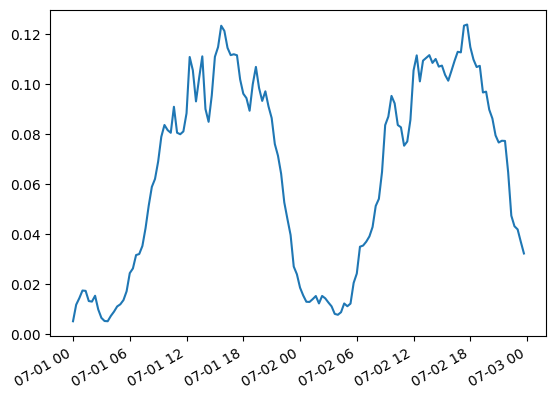

In [76]:
history_by_st.mean()[:144].plot()

In [77]:
history_by_st.head()

,2021-07-01 00:00:00,2021-07-01 00:20:00,2021-07-01 00:40:00,2021-07-01 01:00:00,2021-07-01 01:20:00,2021-07-01 01:40:00,2021-07-01 02:00:00,2021-07-01 02:20:00,2021-07-01 02:40:00,2021-07-01 03:00:00,...,2021-09-30 20:40:00,2021-09-30 21:00:00,2021-09-30 21:20:00,2021-09-30 21:40:00,2021-09-30 22:00:00,2021-09-30 22:20:00,2021-09-30 22:40:00,2021-09-30 23:00:00,2021-09-30 23:20:00,2021-09-30 23:40:00
sid,,,,,,,,,,,,,,,,,,,,,
강원_강릉_HAPPY700 평창시네마,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
강원_강릉_강남동주민센터,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
강원_강릉_강릉축협 하나로마트,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.71,1.00,0.17,0.00,0.00,0.00
강원_강릉_강원도교육연수원,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
강원_강릉_강원양돈농협 하나로마트,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<AxesSubplot: ylabel='Frequency'>

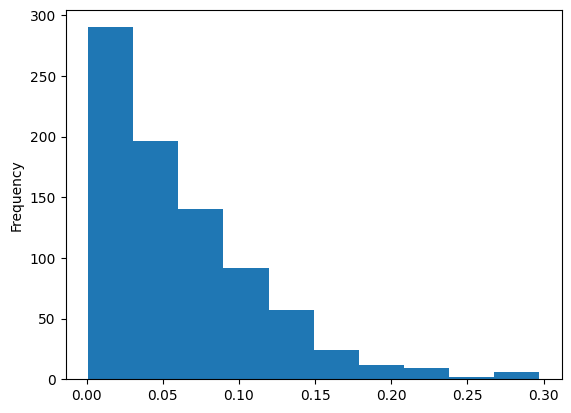

In [78]:
history_by_st.mean(axis=1).plot(kind='hist')

In [79]:
history_by_st.T.reset_index().rename(columns={'index':'time'})

sid,time,강원_강릉_HAPPY700 평창시네마,강원_강릉_강남동주민센터,강원_강릉_강릉축협 하나로마트,강원_강릉_강원도교육연수원,강원_강릉_강원양돈농협 하나로마트,강원_강릉_경포해수욕장,강원_강릉_교2동주민센터,강원_강릉_녹색도시체험센터,강원_강릉_대관령면 관광안내소,...,충북_충주_금릉주차장,충북_충주_노은면 행정복지센터,충북_충주_대소원면 주민자치센터,충북_충주_성서동 공영주차장,충북_충주_이마트 충주점,충북_충주_중앙탑면 행정복지센터,충북_충주_충주시청 민원주차장,충북_충주_충주실내체육관,충북_충주_충주종합스포츠타운,충북_충주_평생학습관
0,2021-07-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2021-07-01 00:20:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2021-07-01 00:40:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2021-07-01 01:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2021-07-01 01:20:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,2021-09-30 22:20:00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6620,2021-09-30 22:40:00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6621,2021-09-30 23:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.78,0.00
6622,2021-09-30 23:20:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [ ]:
history_by_st.T.reset_index().rename(columns={'index':'time'}).to_csv('../data/input_table/fast_history_by_station_pub.csv', index=False)

In [95]:
pub_station.to_csv('../data/main_tables/PUB_STATION.csv', index=False)

### 타깃 변수 smoothing for historic sequence

In [1]:
import pandas as pd

history = pd.read_csv('../data/input_table/fast_history_by_station_pub.csv', parse_dates=['time'])

In [2]:
data = history.set_index('time').T.reset_index().rename(columns={'index':'sid'})

In [3]:
data = data.set_index('sid')

In [4]:
data.head()

time,2021-07-01 00:00:00,2021-07-01 00:20:00,2021-07-01 00:40:00,2021-07-01 01:00:00,2021-07-01 01:20:00,2021-07-01 01:40:00,2021-07-01 02:00:00,2021-07-01 02:20:00,2021-07-01 02:40:00,2021-07-01 03:00:00,...,2021-09-30 20:40:00,2021-09-30 21:00:00,2021-09-30 21:20:00,2021-09-30 21:40:00,2021-09-30 22:00:00,2021-09-30 22:20:00,2021-09-30 22:40:00,2021-09-30 23:00:00,2021-09-30 23:20:00,2021-09-30 23:40:00
sid,,,,,,,,,,,,,,,,,,,,,
강원_강릉_HAPPY700 평창시네마,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
강원_강릉_강남동주민센터,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.7,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
강원_강릉_강릉축협 하나로마트,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.708333,1.0,0.166667,0.0,0.0,0.0
강원_강릉_강원도교육연수원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
강원_강릉_강원양돈농협 하나로마트,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [10]:
historic_data = data.T
historic_data.index = pd.to_datetime(historic_data.index)
historic_data = historic_data.resample(rule='1h').mean().T

In [11]:
historic_data

time,2021-07-01 00:00:00,2021-07-01 01:00:00,2021-07-01 02:00:00,2021-07-01 03:00:00,2021-07-01 04:00:00,2021-07-01 05:00:00,2021-07-01 06:00:00,2021-07-01 07:00:00,2021-07-01 08:00:00,2021-07-01 09:00:00,...,2021-09-30 14:00:00,2021-09-30 15:00:00,2021-09-30 16:00:00,2021-09-30 17:00:00,2021-09-30 18:00:00,2021-09-30 19:00:00,2021-09-30 20:00:00,2021-09-30 21:00:00,2021-09-30 22:00:00,2021-09-30 23:00:00
sid,,,,,,,,,,,,,,,,,,,,,
강원_강릉_HAPPY700 평창시네마,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
강원_강릉_강남동주민센터,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.733333,0.869444,0.0,0.116667,1.000000,1.000000,0.986111,0.233333,0.000,0.000
강원_강릉_강릉축협 하나로마트,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.213889,0.000000,...,0.438889,0.788889,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.625,0.000
강원_강릉_강원도교육연수원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
강원_강릉_강원양돈농협 하나로마트,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
충북_충주_중앙탑면 행정복지센터,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
충북_충주_충주시청 민원주차장,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.122222,1.0,0.047222,0.000000,0.000000,0.000000,0.000000,0.000,0.000
충북_충주_충주실내체육관,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141667,0.705556,0.391667,...,0.000000,0.488889,0.0,0.197222,0.719444,0.200000,0.444444,0.000000,0.000,0.000


In [76]:
import numpy as np

np.repeat(historic_data, 3, axis=1).shape

(1051, 6624)

In [10]:
history_by_st.set_index('time').rolling(window=3, min_periods=1, center=True).mean()

,강원_강릉_HAPPY700 평창시네마,강원_강릉_강남동주민센터,강원_강릉_강릉축협 하나로마트,강원_강릉_강원도교육연수원,강원_강릉_강원양돈농협 하나로마트,강원_강릉_경포해수욕장,강원_강릉_교1동주민센터,강원_강릉_교2동주민센터,강원_강릉_녹색도시체험센터,강원_강릉_대관령면 관광안내소,...,충북_충주_노은면 행정복지센터,충북_충주_대소원면 주민자치센터,충북_충주_성서동 공영주차장,충북_충주_수안보 증원회관,충북_충주_이마트 충주점,충북_충주_중앙탑면 행정복지센터,충북_충주_충주시청 민원주차장,충북_충주_충주실내체육관,충북_충주_충주종합스포츠타운,충북_충주_평생학습관
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2021-07-01 00:20:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2021-07-01 00:40:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2021-07-01 01:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2021-07-01 01:20:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 22:20:00,0.0,0.0,0.625000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.433333,0.0,0.0,0.0,0.0,0.000000,0.0
2021-09-30 22:40:00,0.0,0.0,0.388889,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.433333,0.0,0.0,0.0,0.0,0.258333,0.0
2021-09-30 23:00:00,0.0,0.0,0.055556,0.0,0.0,0.0,0.388889,0.0,0.0,0.0,...,0.0,0.0,0.0,0.152778,0.0,0.0,0.0,0.0,0.591667,0.0
